In [1]:
# 라이브러리 임포트

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import folium
import folium.plugins
from matplotlib import animation,rc
import io
import base64

C:\Users\ASUS\anaconda3\envs\ds_study\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# 데이터 CSV로 불러오기
terror = pd.read_csv('./globalterrorismdb_0718dist.csv', encoding='latin1')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14668\1735330551.py:2: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  terror = pd.read_csv('./globalterrorismdb_0718dist.csv', encoding='latin1')


In [3]:
# 컬럼들의 이름 보기좋게 정리
terror.rename(columns={
    'iyear':'Year', 'imonth':'Month', 'iday': 'Day', 
    'country_txt':'Country', 'region_txt':'Region',
    'attacktype1_txt':'AttackType', 'target1':'Target',
    'nkill':'Killed','nwound' : 'Wounded', 'summary':'Summary', 
    'gname' : 'Group', 'motive' : 'Motive', 
    'targtype1_txt':'Target_type', 'weaptype1_txt':'Weapon_type', 
    'city' : 'City', 'propcomment' : 'Damage'}, inplace = True)

In [4]:
# Columns 정리 잘 되어 있는지 확인
terror.columns

Index(['eventid', 'Year', 'Month', 'Day', 'approxdate', 'extended',
       'resolution', 'country', 'Country', 'region',
       ...
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related'],
      dtype='object', length=135)

In [5]:
# 필요한 컬럼만 추출
terror = terror[['Year', 'Month', 'Day', 'Country', 'Region', 'City', 'latitude', 'longitude', 'AttackType', 'Killed', 'Wounded', 'Target', 'Summary', 'Group', 'Target_type', 'Weapon_type', 'Motive', 'Damage']]

In [6]:
terror['Casualities']=terror['Killed']+terror['Wounded']
terror.head(3)

,Year,Month,Day,Country,Region,City,latitude,longitude,AttackType,Killed,Wounded,Target,Summary,Group,Target_type,Weapon_type,Motive,Damage,Casualities
0,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,Assassination,1.0,0.0,Julio Guzman,NaN,MANO-D,Private Citizens & Property,Unknown,NaN,NaN,1.0
1,1970,0,0,Mexico,North America,Mexico city,19.371887,-99.086624,Hostage Taking (Kidnapping),0.0,0.0,"Nadine Chaval, daughter",NaN,23rd of September Communist League,Government (Diplomatic),Unknown,NaN,NaN,0.0
2,1970,1,0,Philippines,Southeast Asia,Unknown,15.478598,120.599741,Assassination,1.0,0.0,Employee,NaN,Unknown,Journalists & Media,Unknown,NaN,NaN,1.0


In [7]:
# Columns 별 결측값 개수 확인
terror.isnull().sum()

Year                0
Month               0
Day                 0
Country             0
Region              0
City              434
latitude         4556
longitude        4557
AttackType          0
Killed          10313
Wounded         16311
Target            636
Summary         66129
Group               0
Target_type         0
Weapon_type         0
Motive         131130
Damage         123732
Casualities     16874
dtype: int64

In [8]:
# 테러가 많이 일어나는 나라와 지역 그리고 사상자가 많은곳과 그 명수 나타내기
print('Country with Highest Terrorist Attacks:',terror['Country'].value_counts().index[0])
print('Regions with Highest Terrorist Attacks:',terror['Region'].value_counts().index[0])
print('Maximum people killed in an attack are:',terror['Killed'].max(),'that took place in',terror.loc[terror['Killed'].idxmax()].Country)
print('Maximum people killed in an attack are:',terror['Casualities'].max(),'that took place in',terror.loc[terror['Casualities'].idxmax()].Country)

Country with Highest Terrorist Attacks: Iraq
Regions with Highest Terrorist Attacks: Middle East & North Africa
Maximum people killed in an attack are: 1570.0 that took place in Iraq
Maximum people killed in an attack are: 9574.0 that took place in United States


## Step 1

C:\Users\ASUS\anaconda3\envs\ds_study\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


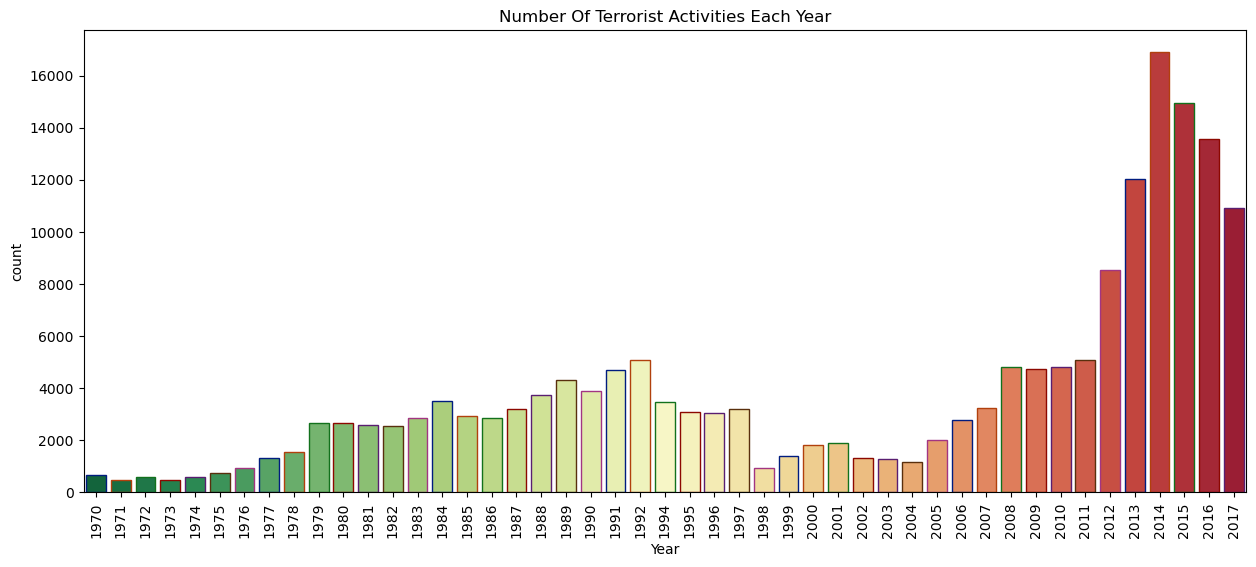

In [9]:
# 테러 일어난 횟수 그래프 표현
plt.subplots(figsize=(15,6))
sns.countplot('Year',data=terror,palette='RdYlGn_r',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Number Of Terrorist Activities Each Year')
plt.show()

### 2011년에서 2012년으로 가면서 급격히 테러가 많이 일어났음을 알 수 있다.
### 네이버 API를 통해 2011년 테러 뉴스를 검색해서 이즈음에 일어난 사고를 파악해보자

In [10]:
# 네이버 API를 통해 2011년 테러를 검색해본다.
import os
import sys
import urllib.request
client_id = "oas1vM5FSwxlyNKdNZgC"
client_secret = "Nvq06g1Mbt"
encText = urllib.parse.quote("2011년 테러")
url = "https://openapi.naver.com/v1/search/news.json?query=" + encText # json 결과
request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
response = urllib.request.urlopen(request)
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    print(response_body.decode('utf-8'))
else:
    print("Error Code:" + rescode)

{
	"lastBuildDate":"Tue, 04 Oct 2022 09:50:36 +0900",
	"total":32199,
	"start":1,
	"display":10,
	"items":[
		{
			"title":"[임병식 칼럼] 한국 민주주의는 어떻게 무너지는가",
			"originallink":"https:\/\/www.ajunews.com\/view\/20221002192841869",
			"link":"https:\/\/www.ajunews.com\/view\/20221002192841869",
			"description":"미국 국민들 또한 9.11<b>테러<\/b> 직후 출범한 부시 행정부에 막강한 권한을 부여하고, 이라크 침공 명분이... 1960~<b>2011년<\/b> 동안 채무한도 조정은 모두 78회(공화당 정부 49회, 민주당 정부 29회)였다. 그렇지만 공화당은 채무한도... ",
			"pubDate":"Mon, 03 Oct 2022 06:02:00 +0900"
		},
		{
			"title":"21년 만에 PS 간다, 감독 10명 교체&amp;169승 에이스 은퇴…암흑기 너무 길었다",
			"originallink":"http:\/\/www.osen.co.kr\/article\/G1111955852",
			"link":"https:\/\/sports.news.naver.com\/news.nhn?oid=109&aid=0004710770",
			"description":"2001년 9월 11일 뉴욕에서 비행기 <b>테러<\/b>가 발생해 미국 전체가 충격에 빠졌기 때문이다. 이후 20년간... 에르난데스는 2010년 아메리칸리그 사이영상을 수상했고 <b>2011년<\/b>부터 2015년까지 5년 연속 올스타에 선정되는 등... ",
			"pubDate":"Sun, 02 Oct 2022 17:15:00 +0900"
		},
		{
			"title":"[뉴스쉽] 하루키, 올해는 노벨 문학상 탈 수 있을까?",
			"

In [11]:
# 뉴스 검색을 위한 함수 만들기
def get_search_url(api_node, search_text, start_num, disp_num):
    base = "https://openapi.naver.com/v1/search"
    node = "/" + api_node + ".json"
    param_query = "?query=" + urllib.parse.quote(search_text)
    param_start = "&start=" + str(start_num)
    param_disp = "&display=" + str(disp_num)
    
    return base + node + param_query + param_start + param_disp


In [12]:
import json
import datetime

In [13]:
def get_result_onpage(url):
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    response = urllib.request.urlopen(request)
    print("[%s] Url Request Success" % datetime.datetime.now())
    return json.loads(response.read().decode("utf-8"))

문제점 datetime.now() 로 찾아서 2022년 뉴스가 검색된다 이걸 어떻게 고쳐야 2011년 뉴스를 찾을 수 있을지..

In [14]:
client_id = "oas1vM5FSwxlyNKdNZgC"
client_secret = "Nvq06g1Mbt"

url = get_search_url("news", "2011년 테러", 1, 5)
one_result = get_result_onpage(url)

[2022-10-04 09:50:40.476197] Url Request Success


In [15]:
one_result

{'lastBuildDate': 'Tue, 04 Oct 2022 09:50:36 +0900',
 'total': 32199,
 'start': 1,
 'display': 5,
 'items': [{'title': '[임병식 칼럼] 한국 민주주의는 어떻게 무너지는가',
   'originallink': 'https://www.ajunews.com/view/20221002192841869',
   'link': 'https://www.ajunews.com/view/20221002192841869',
   'description': '미국 국민들 또한 9.11<b>테러</b> 직후 출범한 부시 행정부에 막강한 권한을 부여하고, 이라크 침공 명분이... 1960~<b>2011년</b> 동안 채무한도 조정은 모두 78회(공화당 정부 49회, 민주당 정부 29회)였다. 그렇지만 공화당은 채무한도... ',
   'pubDate': 'Mon, 03 Oct 2022 06:02:00 +0900'},
  {'title': '21년 만에 PS 간다, 감독 10명 교체&amp;169승 에이스 은퇴…암흑기 너무 길었다',
   'originallink': 'http://www.osen.co.kr/article/G1111955852',
   'link': 'https://sports.news.naver.com/news.nhn?oid=109&aid=0004710770',
   'description': '2001년 9월 11일 뉴욕에서 비행기 <b>테러</b>가 발생해 미국 전체가 충격에 빠졌기 때문이다. 이후 20년간... 에르난데스는 2010년 아메리칸리그 사이영상을 수상했고 <b>2011년</b>부터 2015년까지 5년 연속 올스타에 선정되는 등... ',
   'pubDate': 'Sun, 02 Oct 2022 17:15:00 +0900'},
  {'title': '[뉴스쉽] 하루키, 올해는 노벨 문학상 탈 수 있을까?',
   'originallink': 'https://new

## Step 2

C:\Users\ASUS\anaconda3\envs\ds_study\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


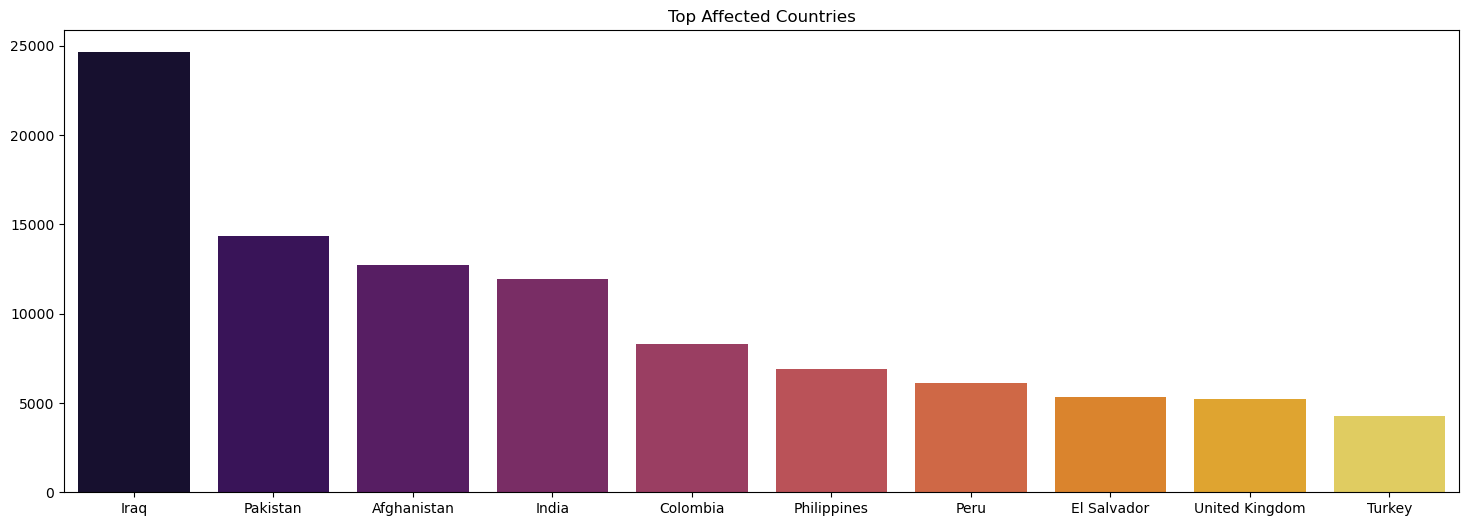

In [16]:
# 나라별 테러현황
plt.subplots(figsize=(18,6))
sns.barplot(terror['Country'].value_counts()[:10].index,terror['Country'].value_counts()[:10].values,palette='inferno')
plt.title('Top Affected Countries')
plt.show()

## Step 3

In [17]:
# 전 세계 테러가 일어난 횟수별 상위 10위 국가에 대해 국가별로 사망자 수와 부상자 수를 구분하여 시각화
terror_Count = pd.pivot_table(terror, index=['Country'],values=["Casualities"])
terror_Count

,Casualities
Country,
Afghanistan,6.711262
Albania,2.210526
Algeria,7.339673
Angola,10.641921
Argentina,1.555858
...,...
Yemen,5.585734
Yugoslavia,2.047120
Zaire,10.562500


In [18]:
terror_Ca=terror_Count.sort_values(by='Casualities', ascending=False)
terror_Ca.head(10)

,Casualities
Country,
South Vietnam,81.000000
Chad,34.413333
Rwanda,26.477707
Barbados,26.333333
Djibouti,21.800000
South Sudan,19.635838
Belarus,18.833333
Japan,18.801609
Ethiopia,15.939394


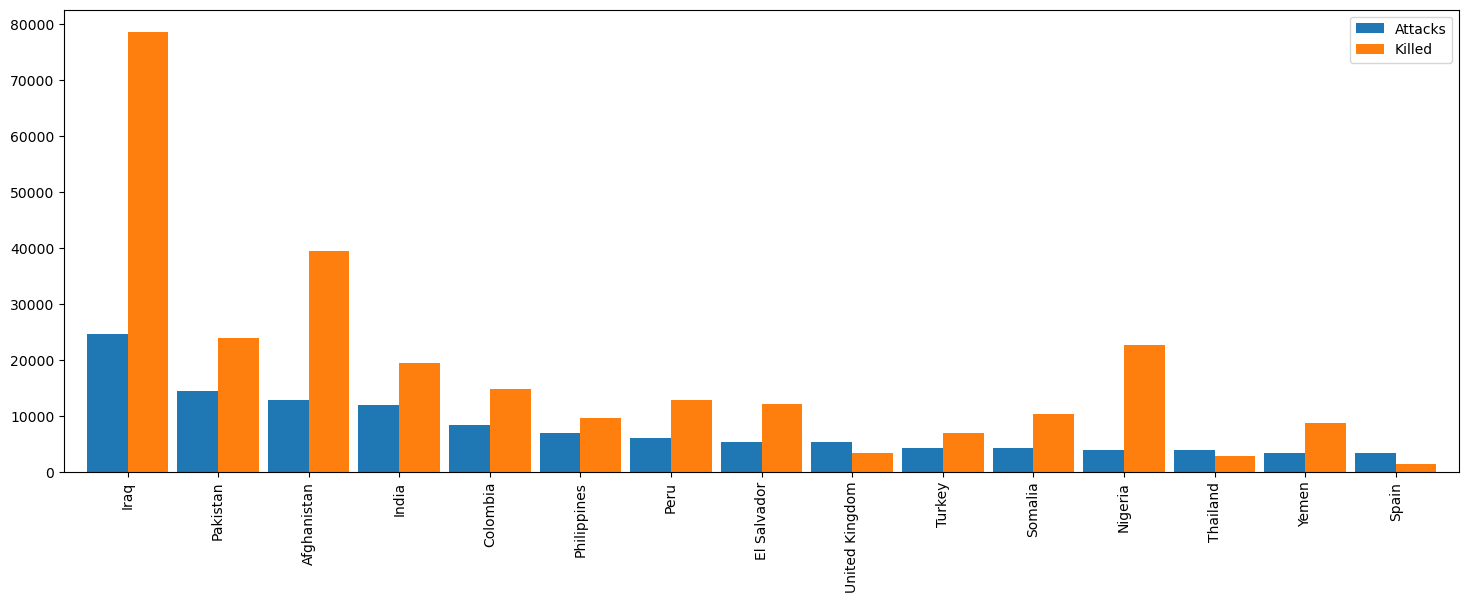

In [19]:
#테러 횟수와 사망자의 비교
coun_terror=terror['Country'].value_counts()[:15].to_frame()
coun_terror.columns=['Attacks']
coun_kill=terror.groupby('Country')['Killed'].sum().to_frame()
coun_terror.merge(coun_kill,left_index=True,right_index=True,how='left').plot.bar(width=0.9)
fig=plt.gcf()
fig.set_size_inches(18,6)
plt.show()

이라크가 특히 횟수에비해 사망자가 매우 많음을 알 수 있다. 아프가니스탄과 나이지리아 또한 횟수에 비해 사망자가 많은 편이다

## Step4

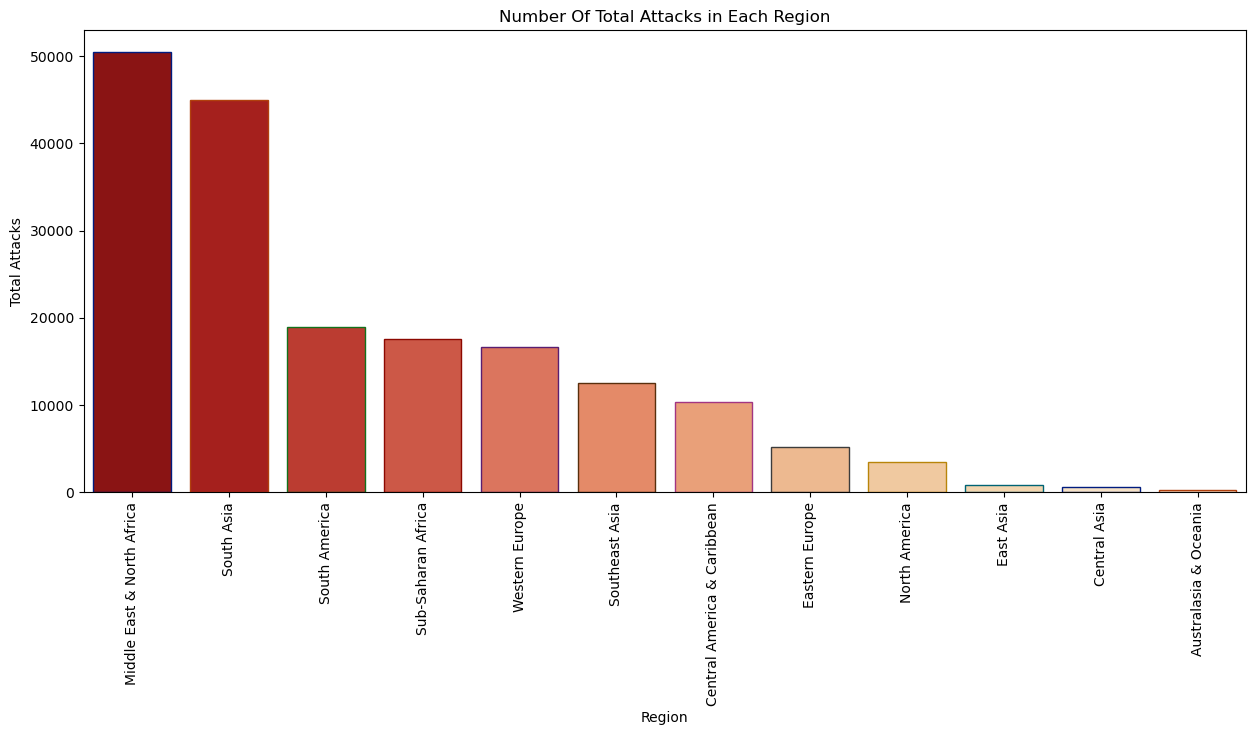

In [20]:
# 지역별 테러횟수 그래프화
region_attacks = terror.Region.value_counts().to_frame().reset_index()
region_attacks.columns = ['Region', 'Total Attacks']
plt.subplots(figsize=(15,6))
sns.barplot(x=region_attacks.Region, y=region_attacks['Total Attacks'], palette='OrRd_r', edgecolor=sns.color_palette('dark',10))
plt.xticks(rotation=90)
plt.title('Number Of Total Attacks in Each Region')
plt.show()

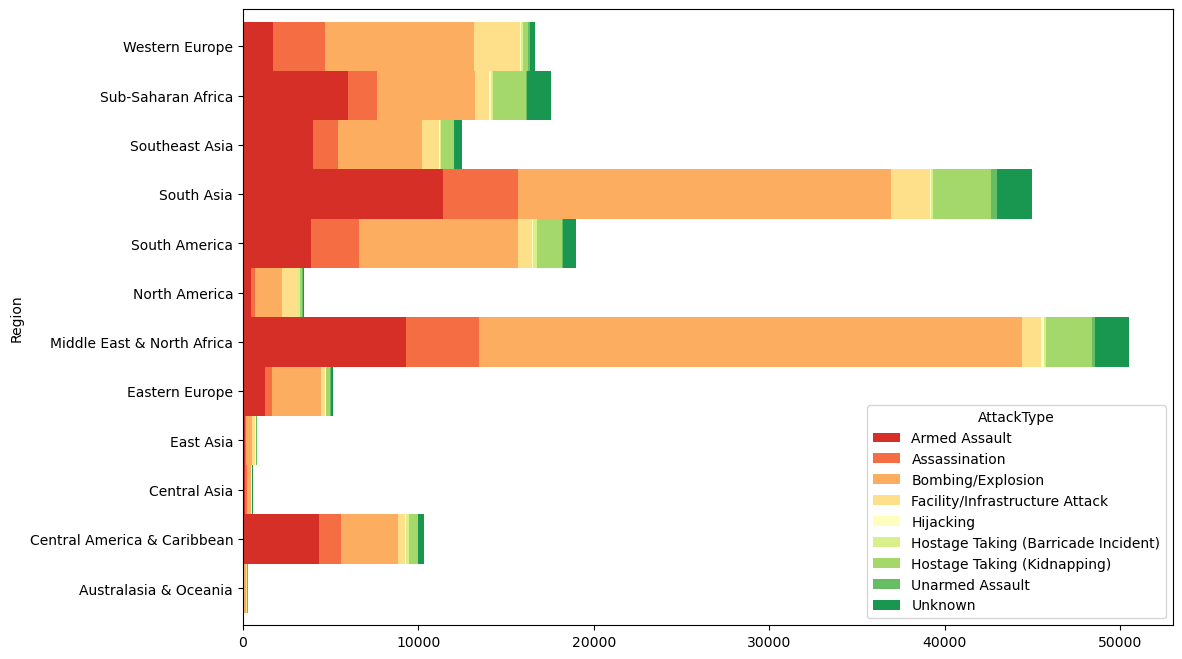

In [21]:
# 지역별 테러의 종류
pd.crosstab(terror.Region,terror.AttackType).plot.barh(stacked=True,width=1,color=sns.color_palette('RdYlGn',9))
fig=plt.gcf()
fig.set_size_inches(12,8)
plt.show()

인프라와 시설중심의 공격이 대부분이고 아프리카의 북쪽과 중동쪽과 남아시아가 특히 많았으며 무장공격이 두번째로 많았음을 알 수 있었다 

## Step5

In [28]:
is_2011 = terror['Year'] == int('2011')


In [29]:
strt = terror[is_2011]

In [30]:
strt

,Year,Month,Day,Country,Region,City,latitude,longitude,AttackType,Killed,Wounded,Target,Summary,Group,Target_type,Weapon_type,Motive,Damage,Casualities
99702,2011,1,1,Egypt,Middle East & North Africa,Alexandria,30.762296,29.696268,Bombing/Explosion,23.0,97.0,Civilians,"01/01/2011: On Saturday at 0000 midnight, in t...",Army of Islam,Private Citizens & Property,Explosives,The specific motive for the attack is unknown.,The attack caused an unknown amount of propert...,120.0
99703,2011,1,1,Iraq,Middle East & North Africa,Baghdad,33.303566,44.371773,Assassination,1.0,0.0,A police colonel,"01/01/2011: On Saturday, on the Mohammed al-Qa...",Unknown,Police,Firearms,The specific motive for the attack is unknown.,The attack caused an unknown amount of propert...,1.0
99704,2011,1,1,Iraq,Middle East & North Africa,Baqubah,33.743240,44.623825,Bombing/Explosion,1.0,1.0,A house of a district mayor,"01/01/2011: On Saturday morning, in Ba'quba, D...",Unknown,Government (General),Explosives,The specific motive for the attack is unknown.,The attack caused an unknown amount of propert...,2.0
99705,2011,1,1,Nigeria,Sub-Saharan Africa,Maiduguri,11.840929,13.141459,Facility/Infrastructure Attack,0.0,0.0,A church was targeted in the attack.,"01/01/2011: On Saturday night, in Maiduguri, B...",Boko Haram,Religious Figures/Institutions,Incendiary,The specific motive for the attack is unknown.,The attack damaged one section of the church.,0.0
99706,2011,1,2,Iraq,Middle East & North Africa,Baghdad,33.303566,44.371773,Armed Assault,1.0,0.0,A government worker,"01/02/2011: On Sunday, in Baghdad city, Baghda...",Unknown,Government (General),Firearms,The specific motive for the attack is unknown.,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104773,2011,12,31,Iraq,Middle East & North Africa,Khan Bani Saad,33.571807,44.536067,Armed Assault,5.0,0.0,5 Sahwa Militia members,12/31/2011: Five members of the Sahwa militia ...,Al-Qaida in Iraq,Terrorists/Non-State Militia,Firearms,Unknown,No property damage reported,5.0
104774,2011,12,31,Pakistan,South Asia,Landi Kotal,34.110325,71.163803,Bombing/Explosion,2.0,13.0,Civilians,12/31/2011: Two children were killed and thirt...,Unknown,Private Citizens & Property,Explosives,Unknown,NaN,15.0
104775,2011,12,31,Iraq,Middle East & North Africa,Kirkuk,35.452110,44.375465,Bombing/Explosion,0.0,1.0,Civilian,12/31/2011: A civilian was wounded when a stic...,Unknown,Private Citizens & Property,Explosives,Unknown,The car was damaged,1.0
104776,2011,12,31,Pakistan,South Asia,Boya,32.945308,69.897046,Bombing/Explosion,2.0,NaN,2 Pakistani soldiers,"12/31/2011: A remote-triggered, homemade roads...",Tehrik-i-Taliban Pakistan (TTP),Military,Explosives,Unknown,The explosion damaged one military vehicle.,NaN


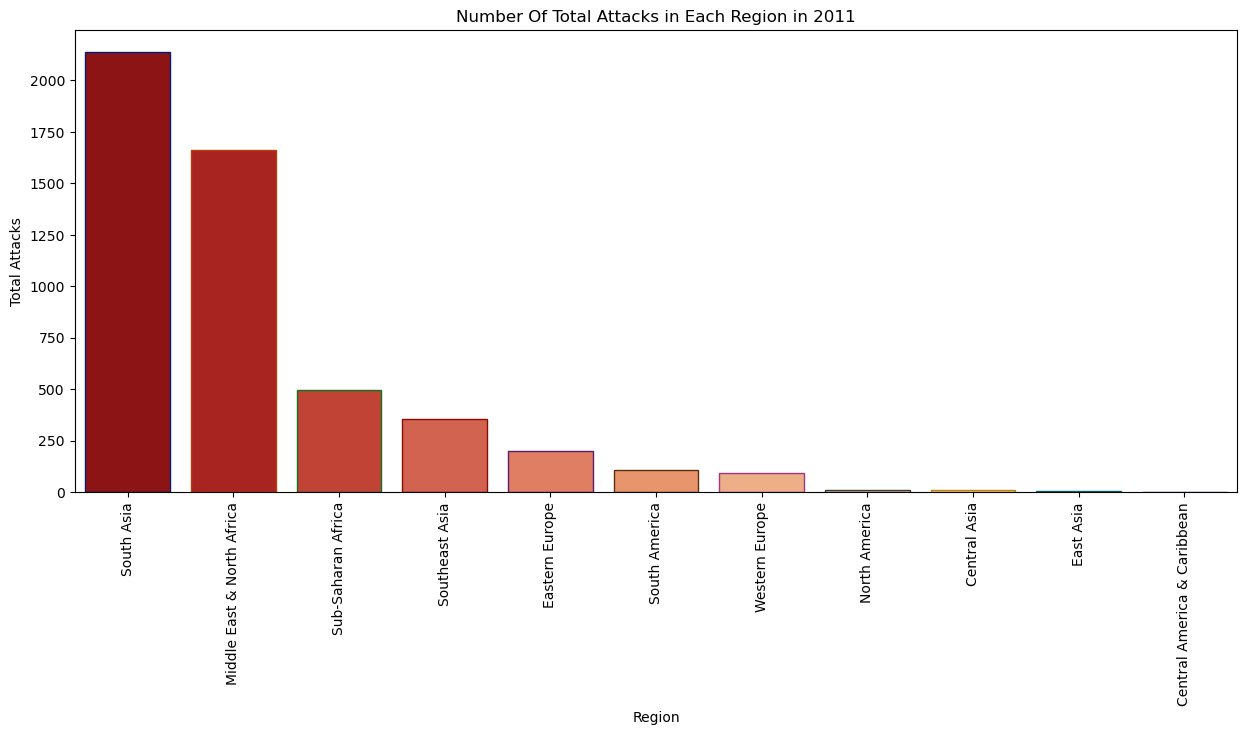

In [32]:
#2011년 테러횟수
region_attacks = strt.Region.value_counts().to_frame().reset_index()
region_attacks.columns = ['Region', 'Total Attacks']
plt.subplots(figsize=(15,6))
sns.barplot(x=region_attacks.Region, y=region_attacks['Total Attacks'], palette='OrRd_r', edgecolor=sns.color_palette('dark',10))
plt.xticks(rotation=90)
plt.title('Number Of Total Attacks in Each Region in 2011')
plt.show()

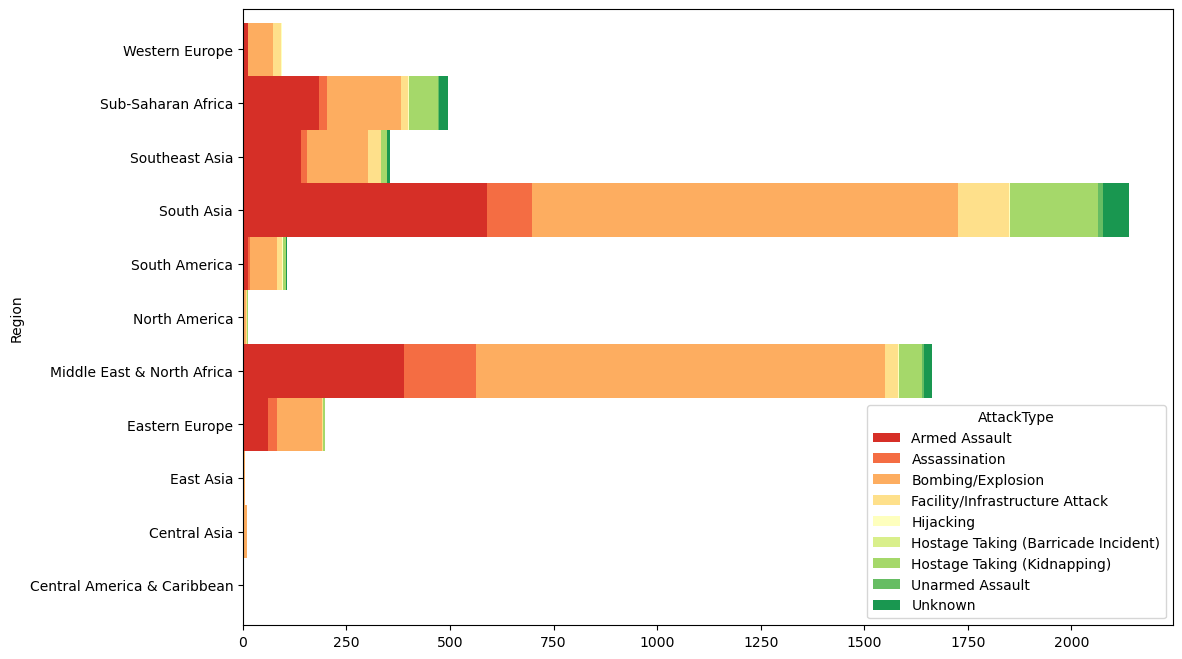

In [31]:
#2011년 테러종류
pd.crosstab(strt.Region,strt.AttackType).plot.barh(stacked=True,width=1,color=sns.color_palette('RdYlGn',9))
fig=plt.gcf()
fig.set_size_inches(12,8)
plt.show()

## Step6

In [38]:
!pip install basemap-data
!pip install basemap-data-hires

  Using cached basemap_data-1.3.2-py2.py3-none-any.whl (30.5 MB)


In [40]:
!pip install basemap

  Using cached basemap-1.3.4-cp38-cp38-win_amd64.whl (443 kB)


In [43]:
from mpl_toolkits.basemap import Basemap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14668\3833280526.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  m.plot(x_group,y_group,'go',markersize=3,color=j,label=i)


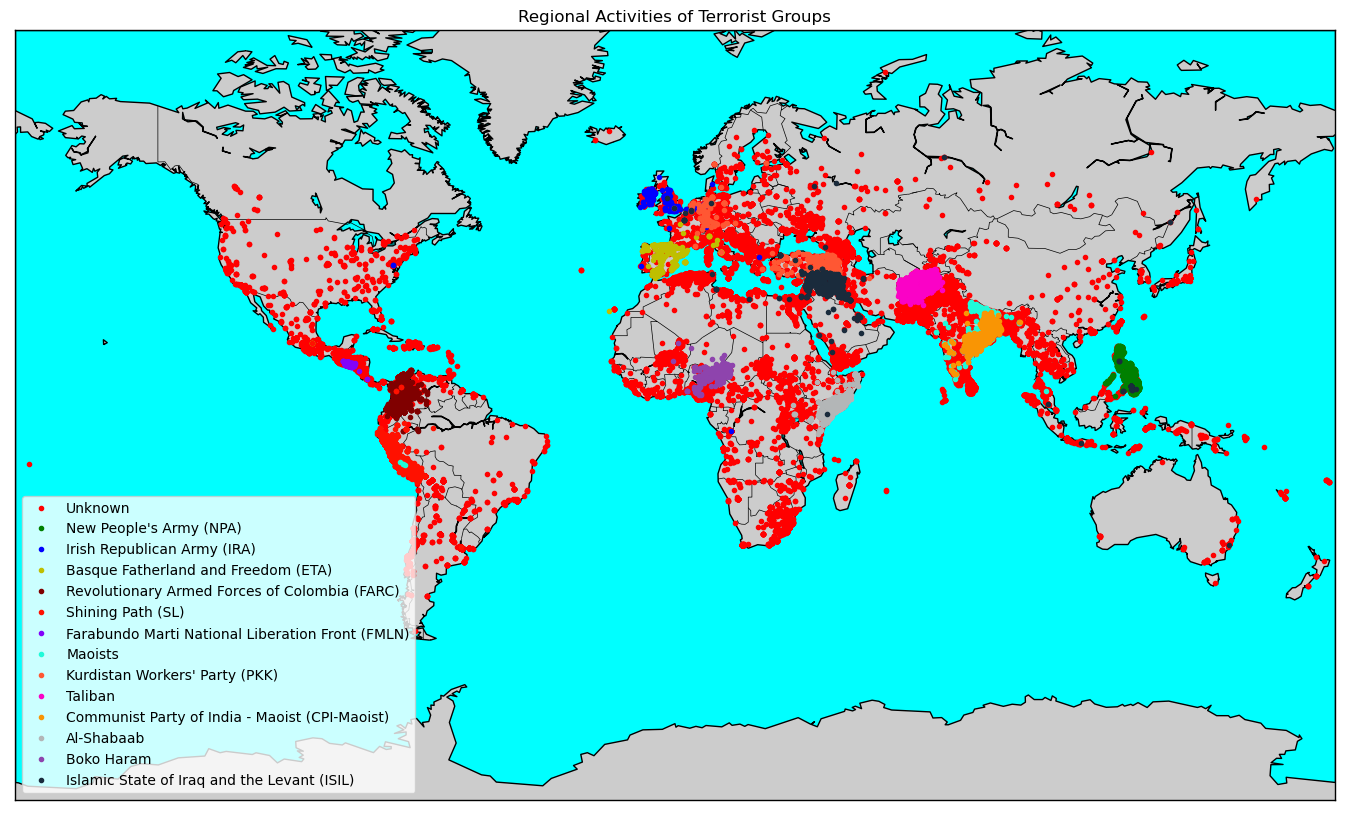

In [47]:
top_groups=terror[terror['Group'].isin(terror['Group'].value_counts()[:14].index)]
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c',lat_0=True,lat_1=True)
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(lake_color='aqua')
m.drawmapboundary(fill_color='aqua')
fig=plt.gcf()
fig.set_size_inches(22,10)
colors=['r','g','b','y','#800000','#ff1100','#8202fa','#20fad9','#ff5733','#fa02c6',"#f99504",'#b3b6b7','#8e44ad','#1a2b3c']
group=list(top_groups['Group'].unique())
def group_point(group,color,label):
    lat_group=list(top_groups[top_groups['Group']==group].latitude)
    long_group=list(top_groups[top_groups['Group']==group].longitude)
    x_group,y_group=m(long_group,lat_group)
    m.plot(x_group,y_group,'go',markersize=3,color=j,label=i)
for i,j in zip(group,colors):
    group_point(i,j,i)
legend=plt.legend(loc='lower left',frameon=True,prop={'size':10})
frame=legend.get_frame()
frame.set_facecolor('white')
plt.title('Regional Activities of Terrorist Groups')
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14668\4044537429.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  m2.plot(x_group,y_group,'go',markersize=3,color=j,label=i)


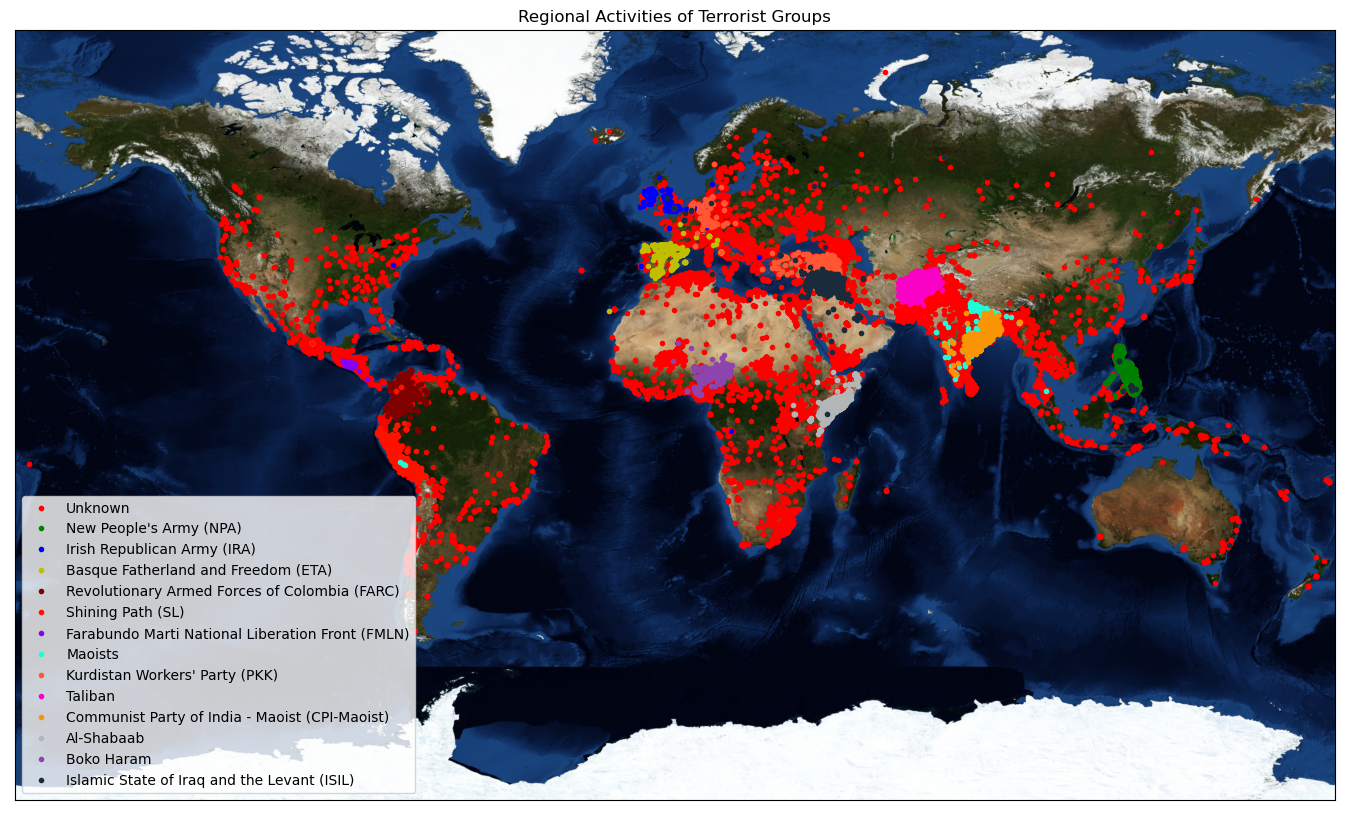

In [48]:
top_groups=terror[terror['Group'].isin(terror['Group'].value_counts()[:14].index)]
m2 = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c',lat_0=True,lat_1=True)
m2.bluemarble()
fig=plt.gcf()
fig.set_size_inches(22,10)
colors=['r','g','b','y','#800000','#ff1100','#8202fa','#20fad9','#ff5733','#fa02c6',"#f99504",'#b3b6b7','#8e44ad','#1a2b3c']
group=list(top_groups['Group'].unique())
def group_point(group,color,label):
    lat_group=list(top_groups[top_groups['Group']==group].latitude)
    long_group=list(top_groups[top_groups['Group']==group].longitude)
    x_group,y_group=m2(long_group,lat_group)
    m2.plot(x_group,y_group,'go',markersize=3,color=j,label=i)
for i,j in zip(group,colors):
    group_point(i,j,i)
legend=plt.legend(loc='lower left',frameon=True,prop={'size':10})
frame=legend.get_frame()
frame.set_facecolor('white')
plt.title('Regional Activities of Terrorist Groups')
plt.show()

생각보다 파악안되는 집단에서의 테러가 많고 각 테러단체가 활동하는지역을 파악할 수 있었다.
세상 곳곳에 테러가 정말 많이 자행되고 있음을 파악할 수 있다.